CNN ile Derin Öğrenme Tabanlı Görüntü Sınıflandırma

In [ ]:
pip install tensorflow scikit-learn matplotlib seaborn tensorboard


# CNN ile Görüntü Sınıflandırma (MNIST & FashionMNIST)

## Amaç
Bu çalışmada Keras kullanılarak Conv2D, MaxPooling2D, Flatten ve Dense katmanlarından oluşan bir CNN modeli kurulmuş ve
MNIST veri seti ile el yazısı rakam tanıma, FashionMNIST veri seti ile kıyafet türü sınıflandırma işlemleri yapılmıştır.
Model performansı train-test ayrımı sonrası accuracy ve confusion matrix ile analiz edilmiştir.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import datetime




# CNN Model Mimarisi

Bu bölümde kullanılacak CNN modeli tek bir fonksiyon ile oluşturulmuştur.
Bu sayede aynı mimari hem MNIST hem de FashionMNIST üzerinde tekrar kullanılabilir.



In [7]:
def build_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    """
    CNN modelini oluşturur.
    input_shape: Görüntü boyutu (MNIST/FashionMNIST için 28x28x1)
    num_classes: Sınıf sayısı (10)
    """
    
    model = models.Sequential(name="CNN_Model") #model tanımlandı

    # Conv2D: Görüntüden özellik çıkarır (kenar, şekil, desen gibi)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
    
    # MaxPooling2D: Boyutu küçültür, önemli bilgileri korur
    model.add(layers.MaxPooling2D((2, 2)))

    # Daha fazla özellik öğrenmek için ikinci convolution katmanı
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten: 2D özellik haritasını 1D vektöre çevirir vektörel düzleştirme işlemi yapar 
    model.add(layers.Flatten())

    # Dense: Öğrenilen özelliklerle sınıflandırma yapar
    model.add(layers.Dense(128, activation="relu"))

    # Çıkış katmanı: softmax ile sınıf olasılıkları üretilir 0-1 arasında sonuç oluşturur 
    model.add(layers.Dense(num_classes, activation="softmax"))

    # Model derleme
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model




 MNIST Veri Seti (El Yazısı Rakam Tanıma)



In [8]:
from tensorflow.keras.datasets import mnist

# Veriyi yükle
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

print("MNIST Train:", x_train_m.shape, y_train_m.shape)
print("MNIST Test :", x_test_m.shape, y_test_m.shape)

# Normalize (0-255 -> 0-1)
x_train_m = x_train_m.astype("float32") / 255.0
x_test_m  = x_test_m.astype("float32") / 255.0

# CNN için kanal boyutu ekle: (28,28) -> (28,28,1)
x_train_m = np.expand_dims(x_train_m, axis=-1)
x_test_m  = np.expand_dims(x_test_m, axis=-1)

# One-hot encoding
y_train_m_cat = to_categorical(y_train_m, 10)
y_test_m_cat  = to_categorical(y_test_m, 10)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
MNIST Train: (60000, 28, 28) (60000,)
MNIST Test : (10000, 28, 28) (10000,)


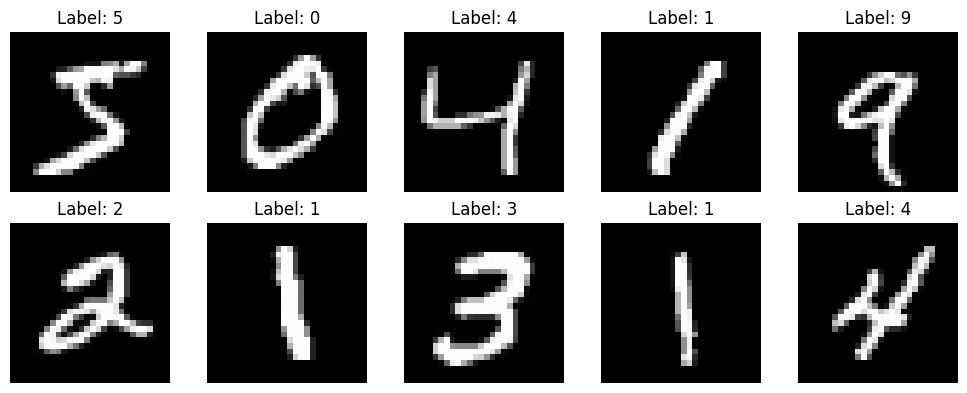

In [9]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train_m[i].squeeze(), cmap="gray")
    plt.title(f"Label: {y_train_m[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Yukarıdaki aşamada rastgele örnek görseller seçilmiş olup görseller; 28x28 çözünürlüğünde gri tonlamalı ve 0-9 arasında rakam etiketleri bulunmaktadır.


# TensorBoard ile MNIST Eğitim Süreci Takibi

Bu bölümde MNIST modeli eğitilirken loss ve accuracy değerleri TensorBoard ile kayıt altına alınmıştır.


In [12]:
import datetime
import tensorflow as tf

# Log klasörü (her çalıştırmada farklı isim)
log_dir_mnist = "logs/mnist_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# TensorBoard callback
tensorboard_callback_mnist = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir_mnist,
    histogram_freq=1
)

print("TensorBoard log dizini:", log_dir_mnist)


TensorBoard log dizini: logs/mnist_20260203-142837


# MNIST Model Eğitimi
Bu bölümde CNN modeli oluşturulmuş ve MNIST veri seti üzerinde eğitilmiştir.


In [ ]:
mnist_model = build_cnn_model()

mnist_model.summary()

history_mnist = mnist_model.fit(
    x_train_m, y_train_m_cat,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tensorboard_callback_mnist]  
)



Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9459 - loss: 0.1811 - val_accuracy: 0.9817 - val_loss: 0.0661
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.9828 - loss: 0.0569 - val_accuracy: 0.9867 - val_loss: 0.0463
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.9873 - loss: 0.0390 - val_accuracy: 0.9873 - val_loss: 0.0467
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.9911 - loss: 0.0280 - val_accuracy: 0.9886 - val_loss: 0.0387
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9930 - loss: 0.0211 - val_accuracy: 0.9879 - val_loss: 0.0401


# Test Accuracy Analizi (MNIST)

Bu bölümde eğitilen modelin test verisi üzerindeki doğruluk (accuracy) performansı hesaplanmıştır.



In [14]:
# Test seti üzerinde model değerlendirme
test_loss, test_acc = mnist_model.evaluate(x_test_m, y_test_m_cat, verbose=0)

print(f"MNIST Test Loss    : {test_loss:.4f}")
print(f"MNIST Test Accuracy: {test_acc:.4f}")



MNIST Test Loss    : 0.0341
MNIST Test Accuracy: 0.9897


## Confusion Matrix (MNIST)

Confusion matrix, modelin her sınıf için doğru ve yanlış tahminlerini detaylı şekilde gösterir.
Satırlar gerçek sınıfları, sütunlar tahmin edilen sınıfları temsil eder.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


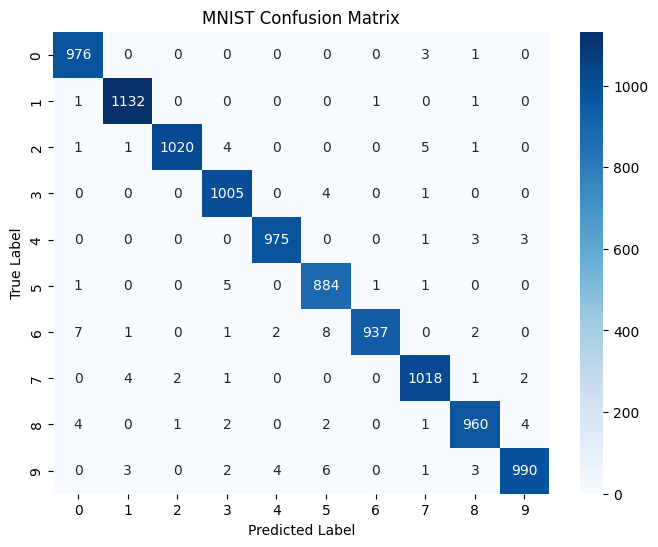

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahmin al
y_pred_probs = mnist_model.predict(x_test_m)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix hesapla
cm = confusion_matrix(y_test_m, y_pred)

# Görselleştir
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("MNIST Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
print(classification_report(y_test_m, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



**Sonuç** 
Model MNIST veri setinde %99 accuracy elde etmiştir. 
Sınıfların tamamında precision/recall/f1-score değerleri 0.98’in üzerindedir. 
Bu sonuç CNN modelinin rakamları yüksek doğrulukla ayırt edebildiğini 
ve sınıflar arasında dengeli bir performans gösterdiğini ortaya koymaktadır.


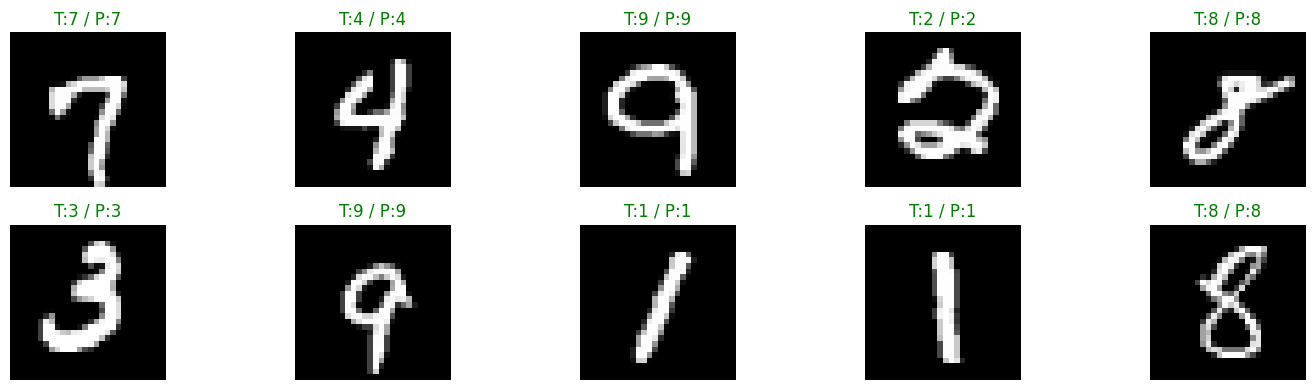

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 10 adet rastgele index seç
random_indices = np.random.choice(range(x_test_m.shape[0]), size=10, replace=False)

# Seçilen görüntüler
images = x_test_m[random_indices]
true_labels = y_test_m[random_indices]

# Tahminler
pred_probs = mnist_model.predict(images, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)

# Görselleştirme
plt.figure(figsize=(15,4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    
    # Doğru tahmin yeşil, yanlış tahmin kırmızı olsun
    correct = (pred_labels[i] == true_labels[i])
    title_color = "green" if correct else "red"
    
    plt.title(f"T:{true_labels[i]} / P:{pred_labels[i]}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()


## TensorBoard ile Eğitim Süreci Takibi

Bu bölümde model eğitimi sırasında kaydedilen loglar TensorBoard aracı ile görüntülenmiştir.
TensorBoard üzerinden eğitim/validasyon loss ve accuracy değerleri epoch bazında takip edilebilir.



In [21]:
%reload_ext tensorboard
%tensorboard --logdir logs/mnist_20260203-142837



Reusing TensorBoard on port 6006 (pid 1776), started 2:30:37 ago. (Use '!kill 1776' to kill it.)